## Introduction
The goal of this analysis was to:
1) Implement minimum variance portfolio (MVP) method as a tool for dealing with risk when investing
2) Analyse how volatility of an asset influences its weight in MVP
3) Analyse how well does MVP method generalise, in other words, can historic data be used for predicting future MVPs

Data from the following assets was used:
1) Oil futures, gold futures, corn futures (Commodities)
2) China equity, US equity, Europe equity, Japan equity (Equities)
3) US 10-year bond (Bonds)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from asset_class import create_asset_class, AssetNames, AssetClassType
from portfolio import get_min_var_weights, Portfolio
from periods import divide_in_periods, std_dev_by_year
from portfolio_series import PortfolioSeries

In [2]:
# Load data for all assets
oil = create_asset_class('../data/Crude Oil WTI Futures.csv',
                            AssetNames.OIL.value, AssetClassType.COMMODITIES)
gold = create_asset_class('../data/Gold Futures.csv',
                        AssetNames.GOLD.value, AssetClassType.COMMODITIES)
corn = create_asset_class('../data/US Corn Futures.csv',
                        AssetNames.CORN.value, AssetClassType.COMMODITIES)

china_equity = create_asset_class('../data/CSI 300 Index ETF.csv',
                                AssetNames.CHINA_EQ.value, AssetClassType.EQUITY)
us_equity = create_asset_class('../data/SPY Index ETF.csv',
                            AssetNames.US_EQ.value, AssetClassType.EQUITY)
europe_equity = create_asset_class('../data/Euro Stoxx 50 ETF.csv',
                                AssetNames.EUROPE_EQ.value, AssetClassType.EQUITY)
japan_equity = create_asset_class('../data/Nikkei 225 ETF.csv',
                                AssetNames.JAPAN_EQ.value, AssetClassType.EQUITY)

us_10_year_bond = create_asset_class('../data/United States 10-Year Bond Yield.csv',
                                    AssetNames.US_10_YEAR_BOND.value, AssetClassType.BONDS)

assets = [oil, gold, corn, china_equity, us_equity, europe_equity, japan_equity, us_10_year_bond]

# Divide asset data into periods
periods = divide_in_periods(assets)

Text(0.5, 1.0, 'Assets ranked by standard deviation for period 2014-2022')

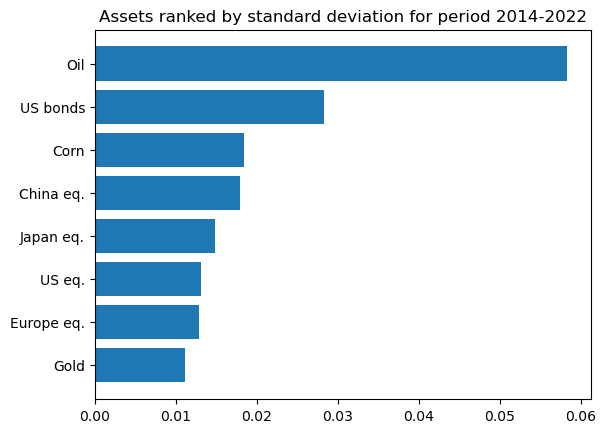

In [3]:
ranked_assets = pd.Series({asset.name: asset.std_dev for asset in assets}).sort_values()
plt.barh(ranked_assets.index, ranked_assets)
plt.title('Assets ranked by standard deviation for period 2014-2022')

Now we want to compute MVP weights for every year to observe how are the weights connected with asset's standard deviation shown above.

Text(0.5, 1.0, 'MVP weights by year')

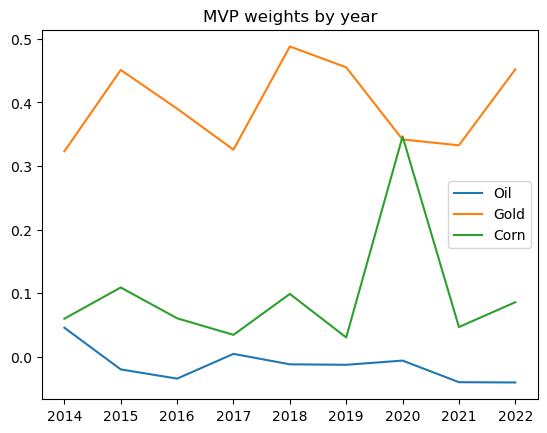

In [4]:
ps = PortfolioSeries([Portfolio(period, get_min_var_weights(
    period.cov_matrix_inv)) for period in periods[:-1]])
years = [period.year for period in periods]
weights_df = pd.DataFrame(index=years)
weights_df["oil"] = {p.period.year: p.weights[0] for p in ps.portfolios}
weights_df["gold"] = {p.period.year: p.weights[1] for p in ps.portfolios}
weights_df["corn"] = {p.period.year: p.weights[2] for p in ps.portfolios}
weights_df = weights_df.dropna()

plt.plot(weights_df["oil"])
plt.plot(weights_df["gold"])
plt.plot(weights_df["corn"])
plt.legend(["Oil", "Gold", "Corn"])
plt.title("MVP weights by year")

We can see that assets with lower standard deviation make up a larger portion of the MVP portfolio, and vice versa. Gold, as an asset with lowest average std, has the the highest weight in the portfolio, while oil, asset with highest std, has the lowest weight. This is expected, since the MVP method seeks to minimize volatility.
Now, lets observe how computing MVP on historical data can be used for predicting future MVPs. 

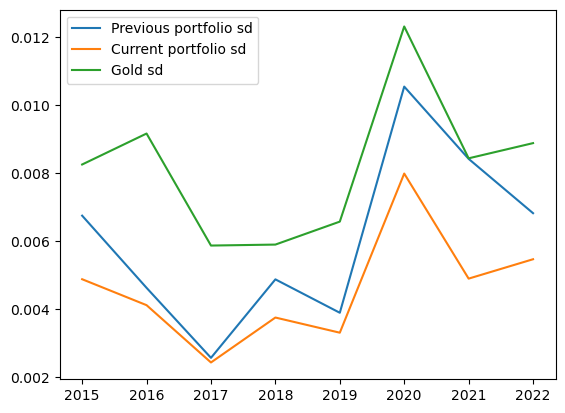

In [5]:
prev_sd = {p.period.year: p.std_dev for p in ps.prev_portfolios if not np.isnan(p.std_dev)}
current_sd = {p.period.year: p.std_dev for p in ps.portfolios if not np.isnan(p.std_dev)}

std_devs = pd.DataFrame(index=years)
std_devs["prev_sd"] = prev_sd
std_devs["current_sd"] = current_sd
std_devs["gold"] = std_dev_by_year("Gold", periods).values
std_devs = std_devs.dropna()

plt.plot(std_devs.index.values, std_devs["prev_sd"])
plt.plot(std_devs.index.values, std_devs["current_sd"])
plt.plot(std_devs.index.values, std_devs["gold"])
plt.legend(["Previous portfolio sd", "Current portfolio sd", "Gold sd"])
plt.show()

The graph above consists of 3 plotlines.\
Orange line (MVP) shows the standard deviation of MVP portfolio for every year. For example, we take data for year 2015 and we compute MVP weights. We then compute daily returns this portfolio would yield if it was used on that same period. From the daily returns, we compute the standard deviation. This is the theoretical minimum of volatility we can achieve by investing in our 8 assets in this period.\
Blue line (MVP') also computes the MVP portfolio, but in a different way. It takes data from one year, computes MVP weights, and then calculates what daily returns would these weights yield if we applied them to the next year's data. For example, we compute MVP for year 2014 and then calculate daily returns and standard deviation for 2015 with these weights. This way, we can compare this model's standard deviation with the one trained on data from 2015 to see how much they differ.\
Green line shows gold's standard deviation. It is here so we can compare its standard deviation (as an asset with lowest std) to portfolio's standard deviations.

We can see that the variability of MVP' over time is closer to that of MVP than that of gold, which suggests that the MVP method is reliable in predicting the minimum variance portfolio, as well as a great diversification tool with the aim of reducing investment risk. The exception is the 2020-2021 period, where lines MVP and MVP' differ more, because of the global pandemic. This suggests that this method is less reliable during sudden changes in market conditions.  

Time window for computing MVP used here was 1 year. The further analysis on MVP method could be to experiment with different time windows to see which one gives the best result to make MVP' as close to MVP' as possible. This can give us information on when to the investment portfolio to keep the investor's risk at minimum.